## The Point Location Problem

### Group 8

Tim Driessen (1006903) <Br>
T.P.H. Hoeijmakers (0996802) <Br>
M.A.J. Timmermans (0962241)
    
***

This Jupyter Notebook will give an extensive explanation of the *point location query problem*. A point location query looks as follows:

    Given a planar subdivision and a query point q specified by its coordinates, find the face of the subdivision containing q. 

The goal of the point location query problem is to pre-process the planar subdivision in such a way that for every query point q, the face of the subdivision containing q can be given efficiently.

In this Jupyter Notebook we will explain two separate algorithms for solving the point location problem. All datastructures such as the doubly-connected edge list, binary search tree, the search structure at the end, and both algorithms that we will discover, are implemented by ourselves. One is encouraged to check out the implementation in the python files, as we will not go into full detail into this notebook here. Rather we implement the modules we have written, and call revelant functions where deemed relevant, and sometimes give an impression about what the class looks like. This notebook should then still give a quite good impression already on how implementation is done.

***
We will first make clear what is meant with a Planar Subdivision.

**Planar Subdivision:** A planar subdivision consists of vertices, edges and faces. An edge is considered to be open. More specifically, an edge is simply a straight line segment in which it’s both endpoints are not included. These endpoints are called vertices. A face is a maximal connected subset of edges.
The subdivision of a planar subdivision is defined as the sum of the number of vertices, edges and faces it consists of.

To represent this planar subdivision into practice we will make use of a so-called doubly-connected edge list. Let's investigate how this datastructure should looks like, and how it is implemented!

**Doubly-connected edge list:** A doubly-connected edge list or DCEL for short is a datastructure that consists of three types of records. These are faces, edges and vertices. Let's have a look at the interface of the DCEL class. 
```python
class Dcel:
    def __init__(self):
        # (x coordinate, y coordinate) -> vertex
        self.vertices_map = {}
        self.hedges_map = HedgesMap()
        self.faces = []
        self.edges = []
        self.outer_face = Outerface()
    def build_dcel(self, points, segments)
    def show_dcel(self, query=None)
    def get_vertices(self)
    def get_edges(self)
    def __add_points(self, points)
    def __add_edges_and_twins(self, segments)
    def __create_outer_face(self, points)
    def __add_next_and_previous_pointers(self)
    def __add_face_pointers(self):
```
A DCEL is made out of a list of undirected edges and a list of endpoints. The $\texttt{build-dcel}$ function is called to initialize it with such an input. A vertex map is maintained to get the existing vertex object for a given $(x,y)$ coordinate in constant time. Similarly we maintain a hedge map that, given an vertex, finds in constant lookup time which hedges the endpoint is the origin of, and which hedges it is the endpoint of. To do this we have created a $\texttt{HedgesMap}$ that maintains $2$ hash maps (one for origin outgoing edges, and one for incoming edges of the endpoint vertex).

Now let's look at the interface of the $\texttt{Edge}$ and $\texttt{HalfEdge}$ class:
```python
class Edge:
    def __init__(self, half_edge1, half_edge2)
    def get_edge_length(self)
    def get_y_at_x(self, x)
    def get_slope(self)
    def point_lies_above_edge(self, point)
    def point_lies_on_edge(self, point)

class HalfEdge:
    def __init__(self, origin, destination):
        self.origin = origin
        self.destination = destination
        self.incident_face = None
        self.twin = None
        self.next = None
        self.prev = None
    def get_length(self)
    def get_angle(self)
```

An edge is the line that seperates two faces in the planar subdivision. We will consider these undirected edges to be equal to the concept of 'segments' and will therefore use these names interchangeably. In a DCEL, such an edge consists of two half-edges in opposite direction, one for each face it borders. These are created from the $\texttt{HalfEdge}$ class. The two half-edges created from the undirected input edge are called each others twin. These half-edges will hold a pointer to its twin, but also the face on its 'left' border and its origin and destination vertex, which we refer to as endpoints of the edge. Half edges also contain pointers to its previous and next half edge. These previous and next half-edges are the other edges that border the face in counter-clockwise direction.
The $\texttt{Face}$ class represents a face of the planar subdivision. 
```python
class Face:
    def __init__(self):
        self.name = None
        self.outer_component = None 
```
It contains a reference to one of the half-edges that form its boundary by means of the $\texttt{outer_component}$. Note that in our connected graph setting, all faces will only have an outer component, except the boundary box which also has an $\texttt{inner-component}$. Therefore the $\texttt{OuterFace}$ class inherits from the $\texttt{Face}$ class with an additional $\texttt{inner-component}$ variable.

Another type of record is a vertex. A vertex contains a location such that the planar subdivision can be plotted. In our implementation of the datastructure, we have also given each and vertex a name, such that the can be labeled.

```python
class Vertex:
    def __init__(self, x, y, name):
        self.x = x
        self.y = y
        self.name = name
```

**Construction Of Dcel**

We will have a high level look of the construction of the DCEL. The $\texttt{build-dcel}(points, segments)$ looks as follows:
```python
    def build_dcel(self, points, segments):
        self.__add_points(points)
        self.__add_edges_and_twins(segments)
        self.__add_next_and_previous_pointers()
        self.__add_face_pointers()
        self.__create_outer_face(points)
```
 - The $\texttt{add-points}$ functions creates vertices of the points (that will later be used as endpoints for segments) and fills the vertices hash map. 
 - The $\texttt{add-edges-and-twins}$ function creates the edges and corresponding half edges objects (with twins) and fills the corresponding $\texttt{hedges-map}$ hashmap. 
 - The $\texttt{add-next-and-previous-pointers}$ is rather interesting. For each halfedge, it needs to be determined what it's next edge is. The technique for this works as follows: Each vertex on the plane is considered. We call $\texttt{hedges-map.get-outgoing-hedges-clockwise(vertex)}$ to get the outgoing half edges belonging to the vertex in clockwise sorted order. Then we traverse these edges and set the next edge of the twin of outgoing half edge to the outgoing half edge that is next in the traversal. The following image should make this idea more clear.
![title](images/clockwise_next_setting.png)
Half edge 1, is the first outgoing half edge considered in the iteration. The twin of this half-edge (half-edge 1') will then have its $\texttt{next}$ component point to half edge 2. This will happen until all edges are considered. It is clear that since each half-edge is an outgoing half edge for precisely one vertex, that after all vertices have been considered, that the $\texttt{next}$ component for each half-edge has been set.

 - The $\texttt{add_face_pointers}$ function creates faces for each cycle of half edges, and set the $\texttt{incident-face}$ field for each half-edge accordingly. Furthermore the $\texttt{outer-component}$ of the face is set to one of the half-edges.

- Finally the $\texttt{create-outer-face}$ function creates an outer face for the input graph.

This datastructure allows for easy traversal of the planar subdivision. For example we can easily find all surrounding half-edges of a face by starting at the half-edge that is the outer-component of the face and continously go to next half-edge of the considered edge until we visited them all. Finding neighbouring faces can just as easily be done by inspecting what face is referenced by both twins of all the half-edge bordering a face.

Before we explain how we implemented the algorithms discussed in this notebook, it is important to know that we assumed general position for all graphs to be used for the algorithms implemented in this notebook. This includes that no two nodes have the same $x$-coordinate. All graphs consist of faces that are simple polygons, and there are no crossing edges. Furthermore, the graph has to be a connected graph.

An example planar subdivision is given below.
***

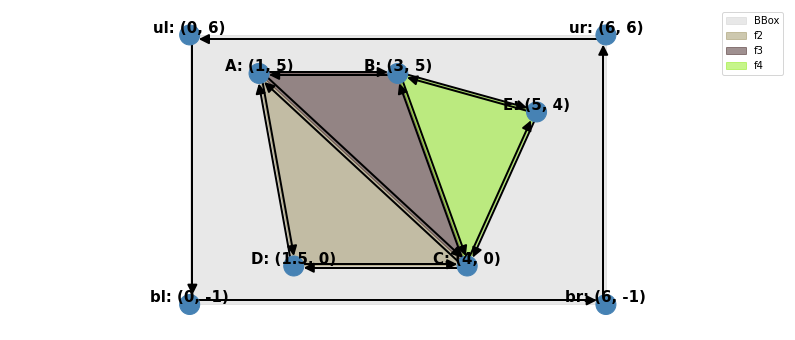

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]  # Set default size of matplot plots in jupyter notebook

import backend.dcel as dcel
import backend.slab_decomposition as sd
import backend.visualization as vs
points = [(1, 5), (3, 5), (4, 0), (1.5, 0), (5, 4)]

segments = [
    [(1, 5), (3, 5)],
    [(3, 5), (4, 0)],
    [(4, 0), (1.5, 0)],
    [(1.5, 0), (1, 5)],
    [(1, 5), (4, 0)],
    [(3, 5), (5, 4)],
    [(4, 0), (5, 4)],
]

myDCEL = dcel.Dcel()
myDCEL.build_dcel(points, segments)

myDCEL.show_dcel()

In our visual representation of the DCEL, vertices are visualized as blue dots and are labeled with a letter followed by their respective $x$- and $y$-coordinate. A half-edge and it’s corresponding twin are represented as two directional edges and a face is visualized by its color with a legend given in the top right.

In the end we want to build a data structure from such a DCEL, that can quickly find the face containing a query point $q$. For example query point $(1.25, 4)$ belongs to face $\texttt{f1}$. <font color="red">Todo: Fix face label</font>

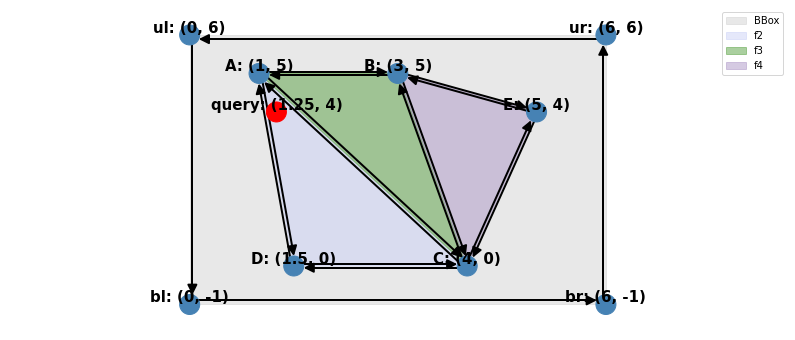

In [22]:
class QueryPoint:
    def __init__(self, x, y):
        self.x = x
        self.y = y

q = QueryPoint(1.25, 4)
myDCEL.show_dcel(q)

### Algorithm 1: Slab Decomposition

The first algorithm we’ll discuss is what we refer to as the ‘slab decomposition’ algorithm. With this algorithm we create a simple, convenient data structure to perform point location queries. The planar subdivision is divided into vertical slabs by drawing vertical lines through all vertices as can be seen below.

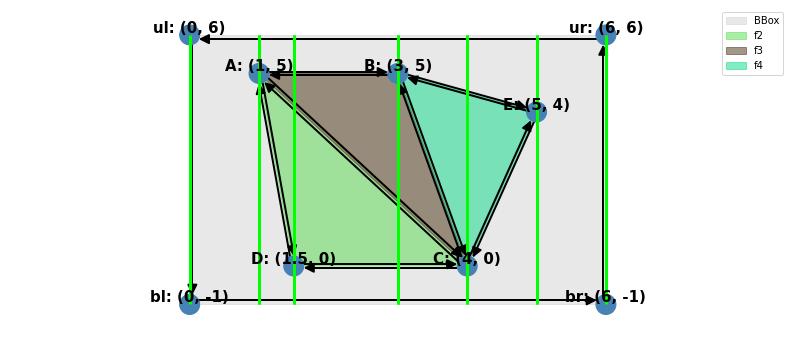

In [23]:
slab_decomposition = sd.SlabDecomposition(myDCEL)
slab_decomposition.show_slab_decomposition()

Because every vertex is responsible for a vertical line of a slab, we must have that within a slab, no vertices are located. Because of this, no edge in the planar subdivision starts or ends within a slab. Therefore all edges intersecting a slab, completely cross the slab. In addition to that, the edges are by assumption not allowed to cross each other. Because of these two properties we have that within a slab, edges can be ordered from top to bottom. Every region between two consecutive edges within a slab belongs to a unique face of the planar subdivision. The regions below and above the lowest and highest edges within a slab, belong to the outer face.

If we now want to find a face containing a query point $q$, we first need to find the slab it belongs to, and after that we want to know above and below which edges of the slab it lies. If we then find a half-edge of the face, $q$ belongs to, we can access the $\texttt{incident_face}$ component to find the face and answer the query.

***
**Creation of the slabs**

A slab object is defined by three main properties: <br>
1.  $\texttt{begin_x}$: x-coordinate left boundary slab <br>
2.  $\texttt{end_x}$: x-coordinate right boundary slab <br>
3.  $\texttt{intersecting_edges}$: The edges intersecting the slab ordered from top to bottom. <br> 

In our code there is actually one additonal component called $\texttt{is_outer_left}$. This property is only set to true for the leftmost slab. To see whether a point is contained within a slab it must be inside $(\texttt{begin_x}, \texttt{end_x}]$ for the corresponding slab values, but for the leftmost slab the left side should be closed as well.

```python
# Returns true if this slab contains the point (x-wise). The left side is considered open and the right side closed for all slabs except the leftmost slab for which both sides are considered closed
def contains_point(self, x_coordinate):
    if self.is_outer_left_slab:
        return self.begin_x <= x_coordinate <= self.end_x
    else:
        return self.begin_x < x_coordinate <= self.end_x
```

We first construct all slabs by walking through all vertices in sorted order and forming a slab for every vertex we visit together with the previously visited vertex (except for the first vertex as it has no previous vertex). In order to then find all edges belonging to a single slab we walk through all edges and see if the edge starts left (or on the boundary) of the slab and ends right (or on boundary) of the slab.

These edges are then all collected and lexicographically sorted on the y-values of the intersection of the edge with the left and right boundary of the slab. First they are sorted on the left intersection y-value and if two edges have the same value here, we compare the right intersection y-value. Having two edges with exactly the same left- and right intersetion y-values is not possible. When this would be the case the edges would overlap which is not allowed by the general assumption. Therefore we must have that a sound ordering among the edges can be found. This is illustrated in the following image:

![title](images/slab-edges-order.png)
***

**Finding the slab containing q**

To find the slab corresponding to query point $q$ we use a binary search tree on the $\texttt{begin_x}$ coordinate of the slabs. We need to guarantee the binary search tree is balanced to ensure an $O(\log n)$ query time for finding the slab of query point $q$. To guarantee this, we first sort the slabs on their $\texttt{begin_x}$ coordinate. From there we take out the middle slab and make it the root node. After that we recurse on the slabs to the left of this middle slab for the left child, and similarly recurse on the slabs to the right of the middle slab for the right child.

Slabs to the left of a node of the binary search tree, have a $\texttt{begin_x}$ coordinate smaller (or equal) than that of the node and slabs to the right have a $\texttt{begin_x}$ coordinate greater than that of the node. By taking the middle slab to be this root node, we have that approximately half of the remaining slabs lie to the left of this node and approximately half of the remaining slabs lie to the right, ensuring the resulting binary search tree is balanced.

```python
# Creates a balanced binary search tree using the slabs sorted on begin_x given as input
def create_bst_x(slabs):
    if not slabs:
        return None
    mid_val = len(slabs) // 2  # Find the middle slab of the sorted list of slabs
    node = TreeNodeX(slabs[mid_val])  # Make the middle slab the root

    # Recurse on left and right part
    node.left = create_bst_x(slabs[:mid_val])
    node.right = create_bst_x(slabs[mid_val + 1:])

    return node
```

Now that we have constructed this binary search tree we find the corresponding slab by simply traversing it from top to bottom, starting from the root. At each node we first check if $q$ is contained within this slab. If this is the case we have found the corresponding slab. If not we continue at the left child when $q.x$ is smaller or equal than the $\texttt{begin_x}$ coordinate of the current node and otherwise we continue at the right child.

In this python code you will see that we keep track of a list called $\texttt{visited}$ instead of returning solely the slab once we have found it. The reason for this is that we want to track the search path to be able to visualize it. Given the set of all visited slabs on the search path, we can quickly find the slab containing $q$ by taking the last slab added to that list.

```python
# Search the bst for the slab that belongs to query point
# It returns all slabs visited. Logically then the last slab visited is the slab of the query
def slab_tree_search(node, key, visited):
    if node is None:
        raise Exception("Query point outside bounding box")  # key not found

    visited.append(node)
    if node.slab.contains_point(key) or (node.left is None and node.slab.begin_x == key): # Special case for leftmost slab
        return visited
    elif key <= node.slab.begin_x:
        return slab_tree_search(node.left, key, visited)
    elif key > node.slab.end_x:
        return slab_tree_search(node.right, key, visited)
```

For the $q = (1.25, 4)$ of the example we will walk through the red marked path of the binary search tree shown below.


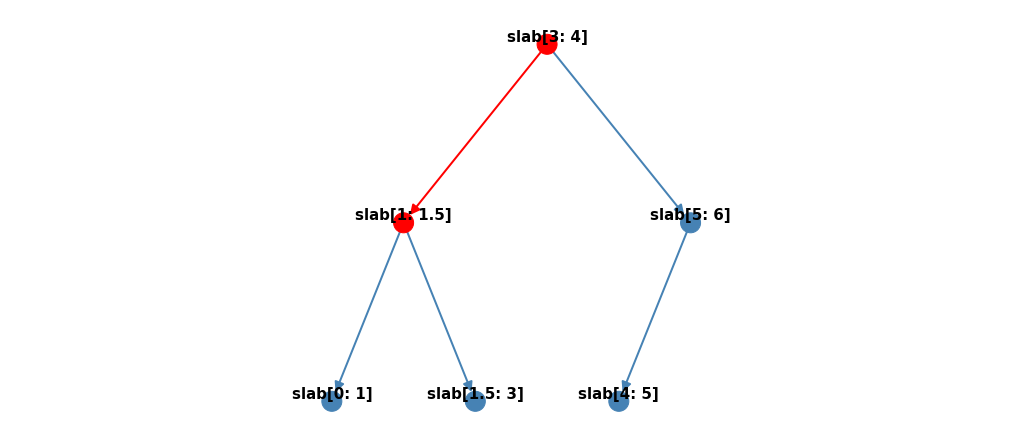

In [5]:
result = slab_decomposition.solve_for_point(q, True)  # True = show bst
slab = result[0]
visited_edges = result[1]
face = result[2]

In the end we find the slab object containing $q = (1.25, 4)$. This is the slab object with $\texttt{begin_x}= 1$ and $\texttt{end_x} = 1.5$. The assumption, we made earlier, that the left boundary of a slab is open and the right boundary of a slab is closed is needed to ensure that a query point lying on such a boundary is not contained in two slabs instead of one.

**Finding the face containing $q$**

Now that we have found the slab. The next step is to find the half edge of the face containing $q$. If we find this half-edge we can simply access the $\texttt{incident_face}$ component which will be the face containing $q$.

To do this we create a binary search tree on the edges going through the slab, ordered from bottom to top. Similarly as with the binary search tree for slabs, we make the middle edge the root node and recurse on the edges to the left of the middle edge for the left child, and recurse on the edges to the right of the middle edge for the right child. This way we ensure a balanced binary search tree.

Now that we have constructed this binary search tree we find the corresponding edge by simply traversing it starting at the root. For each node we calculate what the y-value of the edge of the node would be at the x-coordinate of the query point. Using this we know if the query point lies above or below an edge. For example for the edge going from $A:$ $(1, 5)$ to $C:$ $(4, 0)$, the y-value at $q.x = 1.25$, would be $4.58333$. Since $q.y = 4$, we know that our query point lies below this edge, so we recurse to the left child.

We continue walking this path until we end up in a leaf node. This leaf node must be an edge of the face that contains q. But as we know this edge consists of two half edges, where both half-edges have a different $\texttt{incident_face}$. Therefore we check for the last time if the query point lies above or below the edge. If it lies below, we need the $\texttt{incident_face}$ property of the half-edge pointing to the left. If it lies above, we need the $\texttt{incident_face}$ property of the half-edge pointing to the right.

We return this face, which is our ultimate answer of the query. Again, in the python code, we also include a list called $\texttt{visited}$. This is so we are able to visualize the path taken in the binary search tree. 

```python
# Search the bst of edges for the face that belongs to query point
def face_tree_search(self, node, key_x, key_y, visited):
    if node is None:
        return visited  # key not found

    edge = node.edge[1]  # Retrieve the edge object of the node
    y_edge = edge.get_y_at_x(key_x)  # Calculate the y-value of this edge at key_x

    visited.append(node)
    if key_y < y_edge:
        if node.left is None:
            return visited, node.edge[1].left_arrow.incident_face
        return self.face_tree_search(node.left, key_x, key_y, visited)
    elif key_y >= y_edge:
        if node.right is None:
            return visited, node.edge[1].right_arrow.incident_face
        return self.face_tree_search(node.right, key_x, key_y, visited)
```


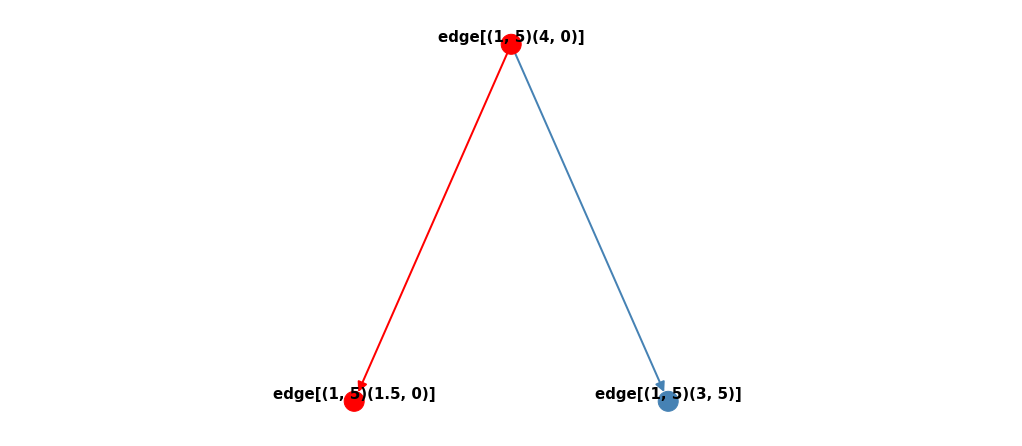

The face containg q is: f2


In [6]:
slab.show_edges_bst(visited_edges)  # Show binary search tree on y-order with marking visited nodes

print("The face containg q is: " + str(face.name))  # Print face

So in the end we find that face $\texttt{f1}$ is the face that contains our query point $q= (1.25, 4)$. Looking at the images of the planar subdivision with our query point, we see that this is indeed correct. So, to find the face containing a query point $q$ we first search the binary search tree containing the slabs as nodes which takes $O(\log n)$ time (with $n$ edges we have at most $O(n)$ vertices). After that we search the binary search tree of the found slab containing at most ($O(n)$ edges), taking $O(\log n)$ time. Thus in total the query time is $O(\log n)$. For a more elaborate explanation we refer to the book.

The slab decomposition algorithm has a construction time of $O(n^2 \log n)$ and has a storage requirement of $\Theta(n^2)$. This will be discussed in more detail in the comparisons part where the two algorithms are compared on different inputs.

### Algorithm 2: Vertical Decomposition
The first algorithm discussed gave a query time of $O(\log n)$. This good query time gives some optism at first sight. Even for $n$ really large, a $O(\log n)$ query time should be a computation that can be done quite fast in theory. Unfortunately a binary search tree is required to find the slab the query point lies in. Then, each slab needs their own binary search tree to locate between which $2$ segments of the slab the query point lies. This gives a worst case space complexity of $O(n^2)$. For $n$ really large the quadratic growth could make the storage rather problematic. Even for a relatively small number such as thousand points the quadradic factor would increase the number to $1.000.000$! It also not hard to imagine that in practice a lot of segments are needed. For example the Netherlands has very concise borders and one would need many segments to store the boundaries. This quadractic storage could also affect the runtime of the query in practice when many IO calls need to be made. Furthermore we have seen that the datastructure required a preprocessing time of $O(n^2 \log n)$ time. For $n$ large this would probably result in a very long preprocessing time, which could be very undesirable in the application of this datastructure. It's therefore clear that it would be good if we can improve on this preprocessing time and space complexity, which brings us to the second algorithm.

**Towards a datastructure with decreased storage complexity**

Have another look at the slab decomposition in the figure of the previous section. As one can see, we only need parts of the vertical lines that are drawn. As a matter of fact, it is sufficient to draw for each endpoint a segment 'upwards' until it hits a segment, and analogously a line downwards until it hits a segment. This division is called the Trapezoidal Map. Observe that in this Trapezoidal Map for each trapezoid, still there is no endpoint contained in it and each point has the same top and bottom segment. Therefore, all points of such trapezoid lie in the same face. The Trapezoidal Map has less trapezoids than in the slab decomposition and thereby removes a large part of the unnecessarily split up faces. As a matter of fact, the trapezoidal map has a linear number of trapezoids as we will see later.

In order to determine in which trapezoid a query point lies, we will need a search structure. We desire this search structure to be built in such a way that it does not use a lot of storage, and gives fast query time. Let's see how to build this search structure.

First we give a set of points segments as input and create a Doubly Connected Edge list of this

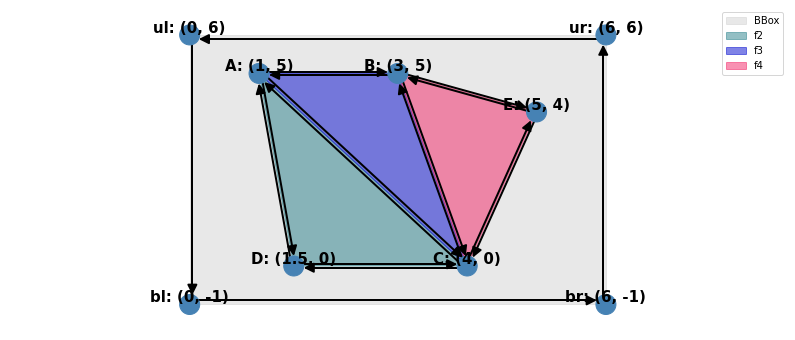

In [24]:
%matplotlib inline
import complex_algorithm.algorithm as ca
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]  # Set default size of matplot plots in jupyter notebook

points = [(1, 5), (3, 5), (4, 0), (1.5, 0), (5, 4)]

segments = [
        [(1, 5), (3, 5)],
        [(3, 5), (4, 0)],
        [(4, 0), (1.5, 0)],
        [(1.5, 0), (1, 5)],
        [(1, 5), (4, 0)],
        [(3, 5), (5, 4)],
        [(4, 0), (5, 4)],
]
myDCEL = dcel.Dcel()
myDCEL.build_dcel(points, segments)
myDCEL.show_dcel()

We have now constructed a doubly connected edge list of the input graph. In the search structure we will distinguish between 3 types of nodes:
- $x$-node: Comparison is done by $x$ coordinate of the query point. That is $query\_point.x < x$ 'go left' and $query\_point.x \geq x$ 'go right'
- Segment-node: Comparison is done by checking whether the query point lies above the segment 'go left' or whether the query point lies below the segment 'go right'. When the query point lies on the line, it is undefined in which the query point should lie. That is, returning either trapezoid is considered okay. In case of querying an endpoint of a segment, the slope of the segment belonging to the query point determines whether the point lies above or below the segment of the node.
- Leaf: These are trapezoid nodes. The corresponding trapezoid will be returned when the search path ends in such a leaf.

In a search structure with these nodes, a query can then be done using a query point and traverse the tree using the above type of comparisons. The leaf the search path then ends in should then be the trapezoid the query point lies in.

Let's first construct the outer face. We will use the DCEL for this, which calculates sufficient distance around the graph in the middle. Then a trapezoid is created for the bounding box. This bounding box trapezoid is the only trapezoid that has an $\texttt{inner-component}$. All other trapezoids only have an $\texttt{outer-component}$ as the graph considered is connected.

In [25]:
import complex_algorithm.search_tree_nodes as ds
import complex_algorithm.search_tree as st
import complex_algorithm.algorithm as alg

segments = myDCEL.get_edges()
outer_face = myDCEL.outer_face
outer_face_trapezoid = ds.Trapezoid(outer_face.bottom_left, outer_face.upper_right,
                                     outer_face.top_segment, outer_face.bottom_segment)


We will now provide an inductive/constructive definition of the search structure. The construction is done by adding segments one by one to the search structure.

(BASE)
The search structure is initialized with the outer trapezoid of the doubly connected edge list. In this base case the search tree will consist out of a single trapezoid node, which is the outer face. Clearly all query points should lie in the bounding box, as this is the area that is considered.

(STEP)
Assumed is that the search tree has been constructed correctly up until the $i$th segment (where $0 \leq i < |\texttt{segments}|$) (Construction Hypothesis). Now the $\texttt{follow_segment}$ function is called on the segment and $\texttt{search_structure}$ to find which trapezoids in the search structure are intersected and store this in $\texttt{intersecting_trapezoid_nodes}$. Then the search structure is accomodated by the $\texttt{replace-intersecting-trapezoid-nodes-for-segment-addition}$ function. This function should remove the intersecting trapezoid nodes from the search structure, as these will no longer exist. The new trapezoids caused by intersection are calculated, and the search structure is changed accordingly. After all segments have been handled it then follows that the search structure has been constructed fully. Correctness of the search structure is now dependent on correctly  determining the intersecting trapezoids and modifying the search structure accordingly. We will later dive into more detail on how this modification of the search structure is done, and how the intersecting rapezoids are determined. 

Let's have a look at the construction of this in the $\texttt{trapezoidal-map-algorithm}$

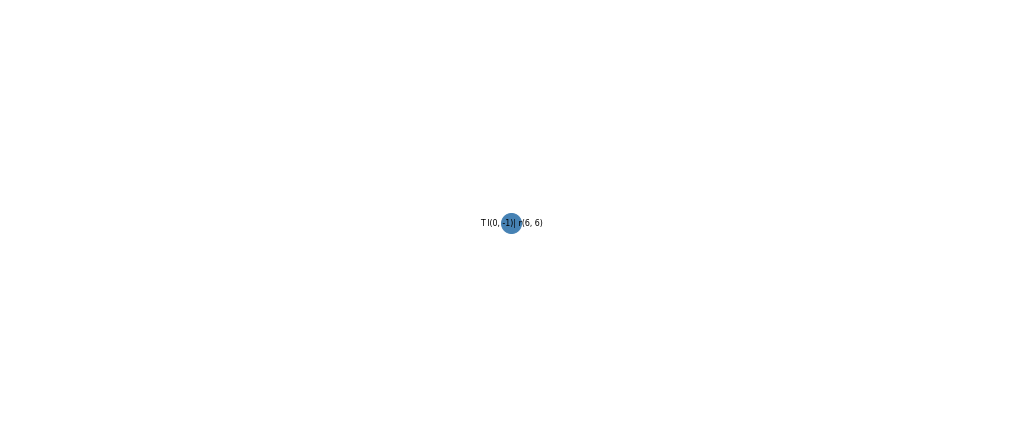

[Edge: [ (1.5, 0), (4, 0)], Edge: [ (1, 5), (1.5, 0)], Edge: [ (3, 5), (5, 4)], Edge: [ (1, 5), (4, 0)], Edge: [ (3, 5), (4, 0)], Edge: [ (1, 5), (3, 5)], Edge: [ (4, 0), (5, 4)]]


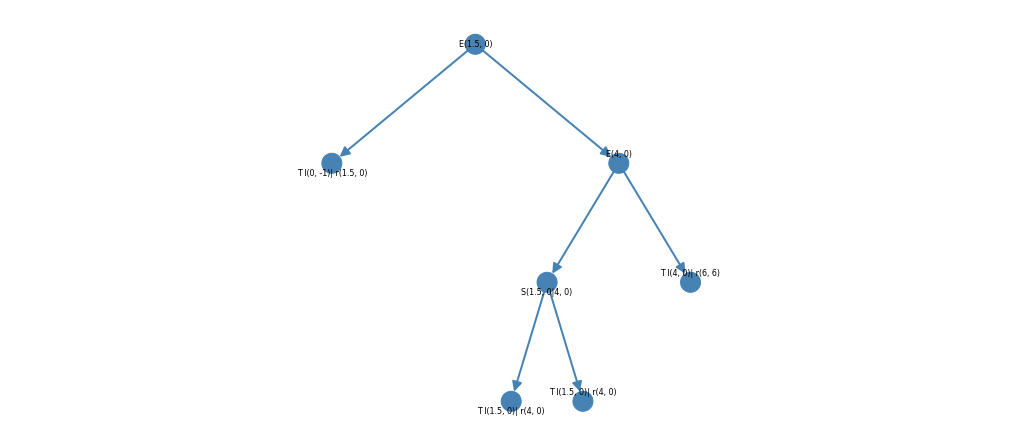

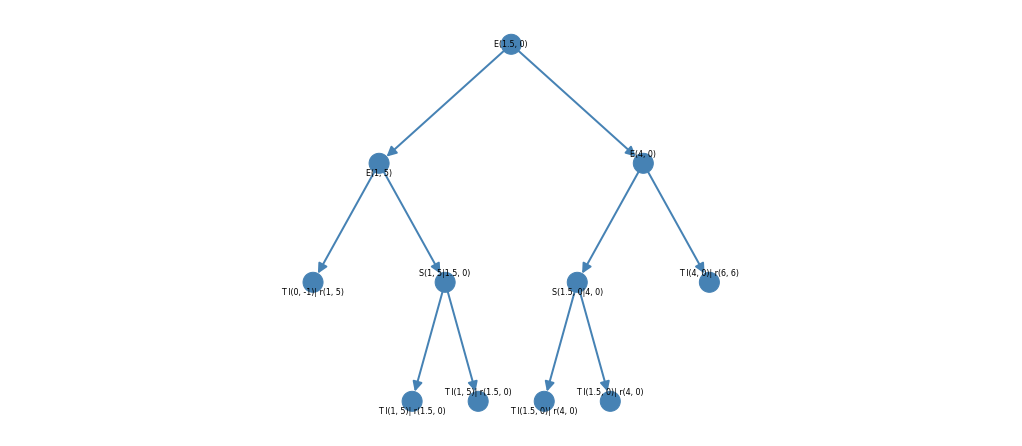

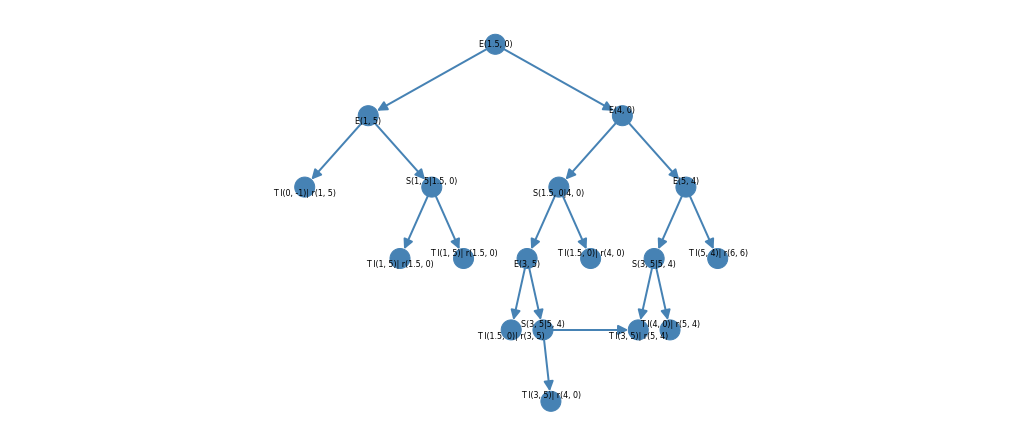

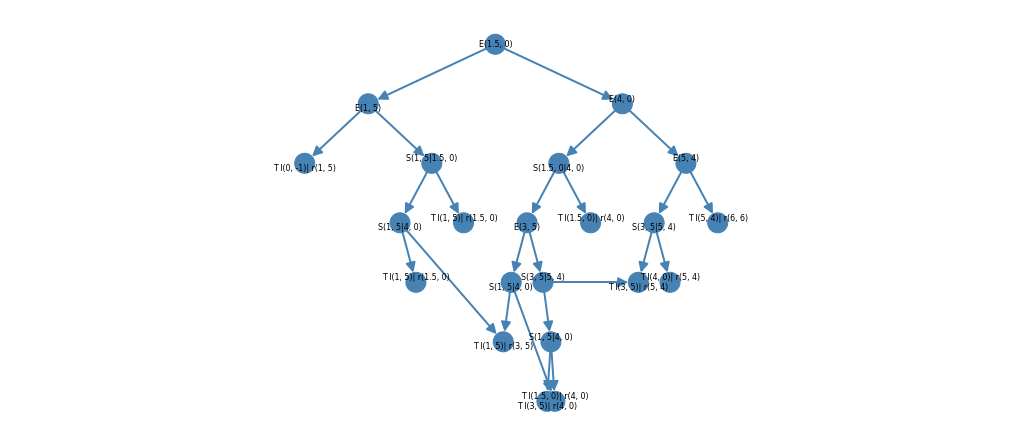

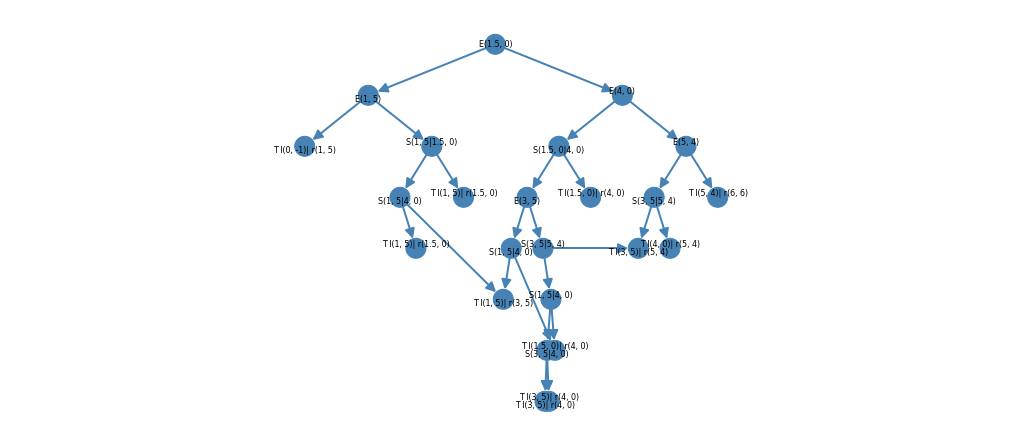

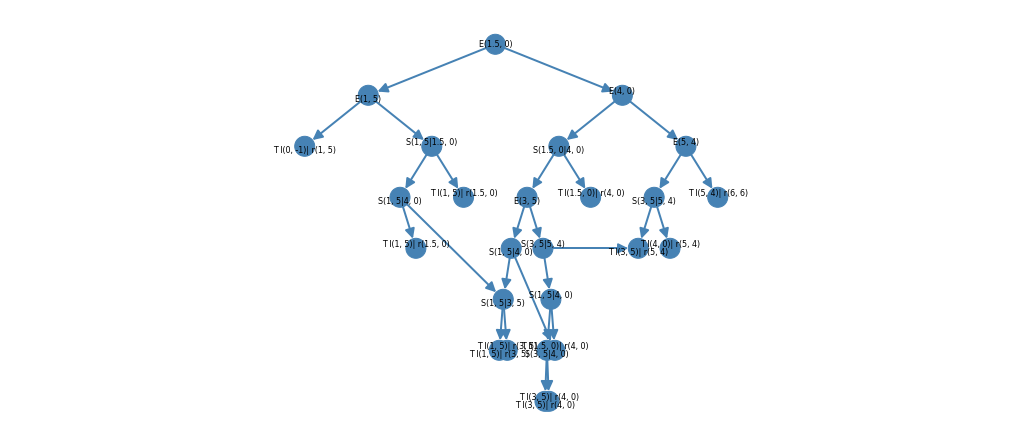

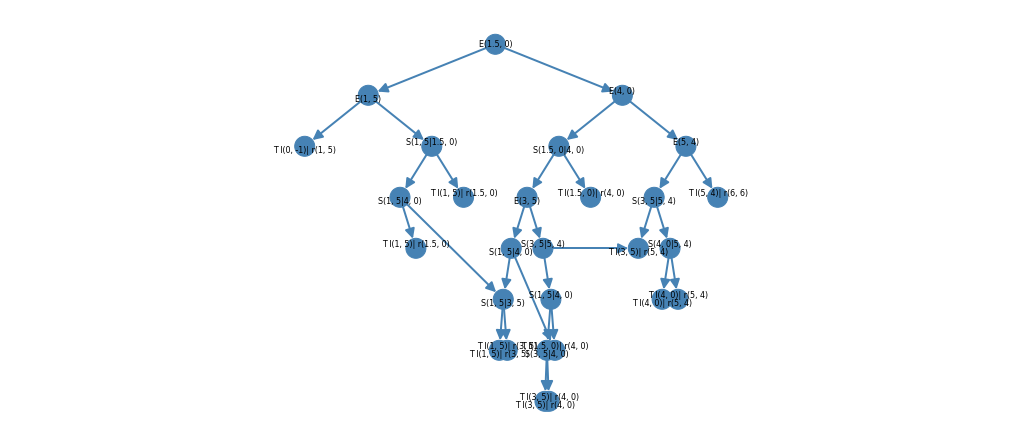

In [26]:
import random as random

# Base:
# Search tree is initialized with the outer_face trapezoid
search_structure = st.SearchStructure(outer_face_trapezoid)
# Print search structure in the base case
search_structure.show_search_structure()


random.shuffle(segments)
print(segments)
#Constructive Step
for segment in segments:
    intersecting_trapezoid_nodes = alg.follow_segment(search_structure, segment) # sorted intersection list
    search_structure.replace_intersecting_trapezoid_nodes_for_segment_addition(intersecting_trapezoid_nodes,
                                                                                   segment)
    search_structure.show_search_structure()

The output of the search structure is a directed acyclic graph (dag). Multiple search paths can lead to the same trapezoid. There is no point in storing the same trapezoid multiple times. Fortunately by using pointers this can be resolved and the tree is constructed as a dag.



**Randomization**

As one can see in the code of the $\texttt{trapezoidal-map-algorithm}$ shown above, the segments are first shuffled and then one by one added to the search structure. In this way we will have a randomized-incremental approach of constructing the search structure. As the above code is executed live, one could be a little disappointed and get a tree that is not so balanced (e.g. an empty branch). When $n$ gets larger it is much more unlickely that a poorly balanced tree pops out since the probability that the segments are in a bad order will decrease (feel free to try the code multiple times to observe that sometimes left branch of the root contains a large subtree, and sometimes it contains only a single node). This randomization technique will give us an expected size of the search structure of $O(n)$. Furthermore queries can then be done in expected time $O(\log n)$ and expected construction time will be $O(n \log n)$. We refer to the book for the proof of this.

Let's now dive into detail on how the tree is modified given a segment and the set of trapezoids of the current search structure that it intersects (i.e. function $\texttt{replace_intersecting_trapezoid_nodes_for_segment_addition}$ is called). 

**Segment is contained in a single trapezoid** 

When a segment is contained in a single trapezoid, only the trapezoid it is contained in needs to be replaced, as all other trapezoid are not affected by this. The search structure will be adjusted as can be seen in following image of the book:
![title](images/segment_in_single_trapezoid.png)
Unfortunately that image does not tell the entire story. It could be the case that the segment connects to another segment on the left-side and/or on its right side via their respective endpoints. Fortunately the replacements do not deviate much from the idea shown in the image. In particular we have the following possible adjustments:
- Only $A,B,C,D$ exist: Replace $\Delta$ by subtree with root $p_i$
- Only $C,D,B$ exist: Replace $\Delta$ by subtree with root $q_i$
- Only $C,D$ exist: Replace $\Delta$ by subtree with root $s_i$
- Only $A,C,D$ exist: Replace $\Delta$ by subtree with root $p_i$ where the right child of $p_i$ is $s_i$

One is encouraged to look up the exact details of this in the $\texttt{__handle_segment_contained_in_single_trapezoid}$ function.

**Segment is contained in multiple trapezoids**

When the set of intersecting edges is $>1$ instead a call to the $\texttt{__handle_segment_contained_in_multiple_trapezoids}$ function is made.
In this situation the story gets more complicated unfortunately. More trapezoids should be removed from the structure, and the newly generated trapezoids should be added to the structure, such that correctness is not affected. The search structure will be adjusted as can be seen in the following image of the book:
![title](images/segment_in_multiple_trapezoids.png)
We will call a function $\texttt{__generate_trapezoids_above_and_below_segment}$ to generate the new trapezoids that would lie above the segment and which new trapezoid would lie below the segment. There are returned as $\texttt{upper-trapezoids}$ and $\texttt{lower-trapezoids}$ respectively. The replacement of the first old trapezoid and last trapezoid would depend on the following cases:
- The first segment starts in an endpoint of a segment: Then $\Delta_0$ is replaced by a segment node with on the left-side $\texttt{upper_trapezoids}[0]$ and on the right-side $\texttt{lower_trapezoids}[0]$.
- The first segment does not start in an endpoint of a segment: Then $\Delta_0$ is replaced by an endpoint node that corresponds to the origin of the segment. On the left-side will be a new trapezoid with $\texttt{leftp}$ the $p_i$ of the image and $\texttt{rightp}$ the origin of the segment. Then on the right side a segment node will be placed that is constructed in the same manner as the above case.

The cases for the last segment are analogous. 

The new trapezoids in the middle will be handled by maintaining the upper and lower trapezoids in a stack like structure $\texttt{upper-trapezoids}$ and $\texttt{lower-trapezoids}$. When removing $\Delta_i$, $\texttt{rightp}(\Delta_i)$ will be considered, and if it is above the segment, the upper trapezoid will be popped. If it is below the segment the lower trapezoid will be popped. This can be seen in the image for trapezoid $A$. $\texttt{rightp}$ of $\Delta_0$ is considered. This is a endpoint that lies below the segment. Hence, a segment node is made with on the left side $front(\texttt{lower-trapezoids})$ and on the right side $front(\texttt{upper-trapezoids})$. Now since this $\texttt{rightp}$ is the rightp of a lower trapezoid, the front of $\texttt{lower-trapezoids}$ will be popped from the stack. Then when $\texttt{righp}$ of $\Delta_1$ is considered, which is an endpoint above the segmeent, again a segment node is made where on the left side of the node will be $front(\texttt{lower-trapezoids})$ and on the right side will be $front\texttt{(upper-trapezoids)}$. Now instead the front of $\texttt{upper-trapezoids}$ will be popped. This idea shows how one trapezoid (in the image $A$) can have multiple incoming arrows.

One is encouraged to look up the exact details of this in the $\texttt{__handle_segment_contained_in_multiple_trapezoids}$ function.

**Follow Segment: Finding the trapezoids a segment intersects**

To find the intersecting segments of a segment, a call to $\texttt{follow_segment}$ is made. The idea, that it uses the existing search structure to navigate to the trapezoid the origin endpoint lies in. Then, it walks through the trapezoidal map by checking whether the segment destination is further to right than the $\texttt{rightp}$ of the trapezoid it is currently in. Depending on whether $\texttt{rightp}$ of the current trapezoid is above or below the segment, the $\texttt{upper-right-neighbour}$ or $\texttt{lower-right-neighbour}$ is correctly taken. This is done repetitively until we reach the final trapezoid in which the segment its destination point lies in, and the set of trapezoids we visited in this procedure is reported. Note that an implication of this is that we need to maintain the neighbours of each generated trapezoid in the construction process. This is a rather tedious procedure, and we refer to the source code to see how this is maintained at creation of new trapezoids. Since the $\texttt{follow-segment}$ function is an important but compact function, we will list it here as a reference to the reader.

```python
# Returns the list of trapezoids in the search structure that intersect with segment
# POST: delta_node_list contains all the trapezoids in the search structure that intersect with segment.
#       delta_node_list is sorted on vertical intersection
def follow_segment(search_structure, segment):
    p = segment.origin
    q = segment.destination


    # delta_node_0 is the trapezoid segment.origin lies in
    delta_node_0 = search_structure.query_for_adding_segment(p, segment)
    # Remark: p is the origin of the segment. One might think problems will arrive if
    # p starts on an endpoint. However, this is treated as if it lies slightly to the right.
    # Then the trapezoid in which the segment first "enters" is assigned to delta_node_0
    # This is desired behaviour, as this is indeed what we expect to be the first element of reporting list

    delta_node_j = delta_node_0
    delta_node_list = [delta_node_0]
    # While q lies to the right of rightp
    while q.x > delta_node_j.trapezoid.rightp.x:
        # Delta_j.rightp lies above segment
        if delta_node_j.trapezoid.rightp.y > segment.get_y_at_x(delta_node_j.trapezoid.rightp.x):
            delta_node_j_plus_1 = delta_node_j.trapezoid.lower_right_neighbour.trapezoid_node
        # Delta_j.right lies below segment
        else:
            delta_node_j_plus_1 = delta_node_j.trapezoid.upper_right_neighbour.trapezoid_node
        delta_node_list.append(delta_node_j_plus_1)
        delta_node_j = delta_node_j_plus_1
    return delta_node_list
```

**Testing the algorithm**

We have now constructed the key components of our algorithm. The $\texttt{follow-segment}$ can determine for a given existing search structure, and a segment, which trapezoids of the search structure the segment intersects. The $\texttt{replace_intersecting_trapezoid_nodes_for_segment_addition}$ can then accomodate the existing search structure by removing the intersecting trapezoids, and insert the appropriate the new ones. At termination of this procedure we can get all trapezoids by returing all leafs. This set of trapezoids is the $\texttt{Trapezoidal-Map}$.

Let's check if the trapezoidal map looks as we would expect for our input graph.

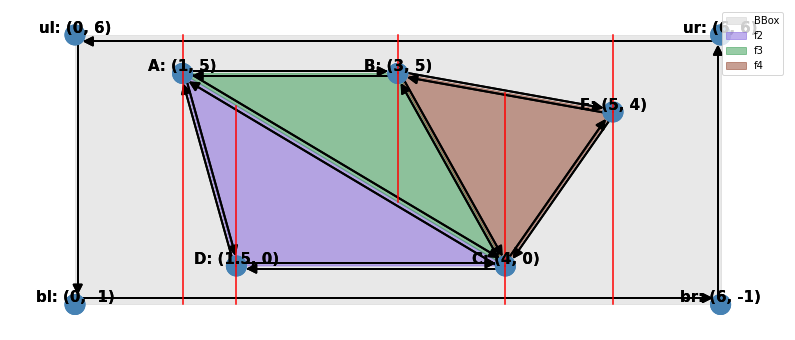

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]  # Set default size of matplot plots in jupyter notebook

trapezoidal_map = st.TrapezoidalMap(myDCEL, search_structure.get_all_trapezoids())
trapezoidal_map.show_vertical_decomposition()



Indeed, this the trapezoidal map one would expect on a graph like this. Now let's perform a query on it. 


Trapezoid : leftp: (1, 5), rightp: (3, 5) top: Edge: [ (1, 5), (3, 5)], bottom: Edge: [ (1, 5), (4, 0)] 
Face: f3


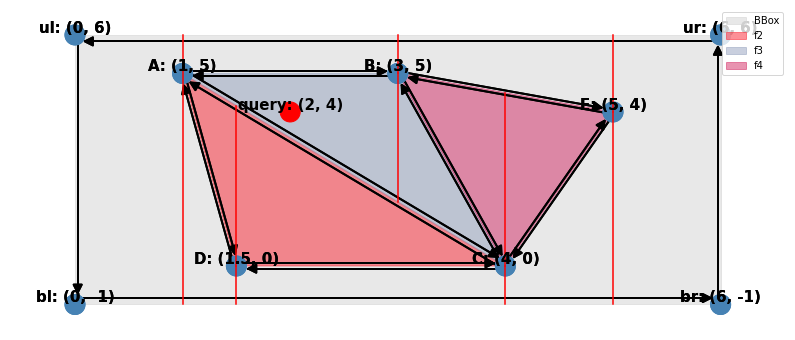

In [28]:
query_point = QueryPoint(2,4)
trapezoid = search_structure.query(query_point).trapezoid
print(trapezoid)
print("Face: " + trapezoid.bottom.right_arrow.incident_face.name)

trapezoidal_map.show_vertical_decomposition(query_point)

As you can see in the textual output of the above figure, the correct trapezoid is reported. Remember that our final answer should not be the trapezoid it lies in, but use the information of the trapezoid to determine the face. Fortunately by construction of the DCEL this is now a rather simple procedure. We simple check what the bottom edge of the trapezoid is and for the 'right-pointing arrow' we check which face lies incident to it and report this.

Some code has been added to do this querying interactively below. One is encouraged to try this out, and see the correct face popping up on the label on the left side of the figure!

In [29]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]  # Set default size of matplot plots in jupyter notebook
fig = plt.figure()

trapezoidal_map = st.TrapezoidalMap(myDCEL, search_structure.get_all_trapezoids())
trapezoidal_map.show_vertical_decomposition()



def onclick(event):
    query_point = QueryPoint(round(event.xdata, 2), round(event.ydata, 2))
    t = search_structure.query(query_point).trapezoid
    plt.clf()
    face_name = t.bottom.right_arrow.incident_face.name
    trapezoidal_map.show_vertical_decomposition(query_point)
    ax = plt.gca()
    text=ax.text(0.5,0, "", va="bottom", ha="left")
    text.set_text("Face: " + face_name)
    #print(t)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Comparison between Slab Decomposition and Vertical Decomposition Algorithm

We have seen 2 different algorithms to solve the point location problem. Let us first summarize how these compare to each other.
 
|                  | Slab Decomposition    | Vertical Decomposition
|------------------|-----------------------|-----------------------
|   Construction   | $O(n^2 \log n)$       | $O(n \log n)$
|   Query          | $O(\log n)$           | $O(\log n)$
|   Storage        | $\Theta(n^2)$         | $O(n)$

We have reached a performance gain in construction of factor $n$. Furthermore we see a significant difference in worst case storage complexity, namely exponential versus a linear amount of storage. Then again, we should be aware that these are only worst case complexities. It only tells us something about the performance/storage when the the argument keeps growing. Furthermore, the constants are hidden and it could be that this worst case complexity is only reached in some very rare cases. In this section we will try to look a bit further than these complexities, and inspect some time/storage measures of the algorithms in practice.

It is good to think about where this $O(n^2)$ in storage of the Slab Decomposition comes from. Consider the situation where we have $n/2$ segments layed out as in the figure.

![title](images/trapezoid-exponential.png)

As one can see, in the first layer we have $n+1$ regions it is divided into by every endpoint of the input. Then on the layer below, since 2 endpoints 'drop out' we have $n-1$ regions etc... This sequence solves to $\frac{n^2}{4}$ regions in total which indeed is a quadratic number of regions. It then follows that the binary search trees have $\Theta(n^2)$ nodes in total. Furthermore construction of binary seach trees can be done in $O(\alpha \log \alpha)$ where $\alpha$ is the number of nodes. Hence it follows that we have a construction of $O(n^2 \log n)$. 

On the other hand, when considering the vertical decomposition we always have the following:
$\begin{cases} 
\text{endpoints of segments} &\leq 2n\\
\text{endpoints of vertical extensions} &\leq 2\cdot 2n\\
\text{Vertices of bounding box} &\leq 2\cdot 4
\end{cases}$

It follows that the number of vertices is $\leq 6n + 4$. Then we can only have $\leq 3n+1$ trapezoids. Let's see how the vertical decomposition would look like on this problem instance.

![title](images/trapezoid-linear.png)

Indeed, only a linear number of trapezoids are needed. One would expect this example, to be good to see that the Vertical Decomposition will outperform the Slab Decomposition both in construction and in storage. We will try some examples below and see if it is indeed the case. We first use our generator function to show a DCEL of such a setting with 5 faces + Bounding box.


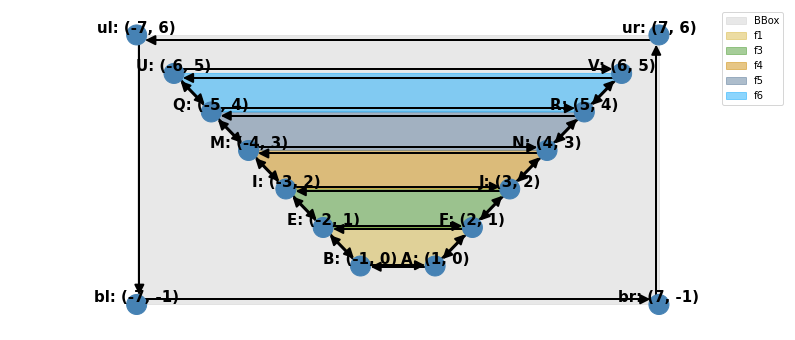

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]  # Set default size of matplot plots in jupyter notebook
import graph_generation.graph_generator as generator
import backend.slab_decomposition as sd
import complex_algorithm.algorithm as ca

points, segments = generator.create_expanding_graph(5)
myDCEL = dcel.Dcel()
myDCEL.build_dcel(points, segments)
myDCEL.show_dcel()

Let's now see how the slab decomposition algorithm compares to the vertical decomposition on the above setting in practice. We will compare construction time, query time and storage. We will test this on a setting with $5,10,50,100,300,500$ and $1000$ faces. Hence we consider a situation of $\#segments = 3\#faces+1$. One would expect, in particular on the larger input graphs, the Vertical Decomposition algorithm to outperform the Slab Decomposition algorithm since the complexity has a factor $n$ less. On the other hand both algorithms have the same query time complexity, so a similar growth should be expected there. Finally, the slab decomposition algorithm uses $O(n^2 \log n)$ storage, whereas the vertical decomposition algorithm has an expected storage of $O(n)$. Therefore, we would expect to see a growth that is even faster than quadratic for the slab decomposition algorithm, but only a linear growth in the vertical decompisition. Let's see how it performs!

In [14]:
import time

test_cases = [5, 50, 100, 300, 500, 750, 1000]

slab_decomposition_construction_time = []
slab_decomposition_query_time = []
slab_decomposition_nodes = []


vertical_decomposition_construction_time = []
vertical_decomposition_query_time = []
vertical_decomposition_nodes = []



for case in test_cases:
    number_of_faces = case
    points, segments = generator.create_expanding_graph(number_of_faces)
    myDCEL = dcel.Dcel()
    myDCEL.build_dcel(points, segments)


    start = time.time()
    slab_decomposition = sd.SlabDecomposition(myDCEL)
    end = time.time()
    construction_time = end - start
    slab_decomposition_construction_time.append(construction_time)
    print("Slab decomposition: Construction with " + str(number_of_faces) + " faces uses "+ str(construction_time) + " seconds ")

    query_point = QueryPoint(0, number_of_faces-0.5) # To get a query point entirely on top
    start = time.time()
    t = slab_decomposition.solve_for_point(query_point, False)
    end = time.time()
    query_time = end - start
    slab_decomposition_query_time.append(query_time)
    print("Slab decomposition: Time to query a point is " + str(query_time) + " seconds ")
    
    structure_size = slab_decomposition.get_size_total()
    slab_decomposition_nodes.append(structure_size)
    print("Slab decomposion: Size of the search structure " + str(structure_size) + " nodes ")


    start = time.time()
    search_structure, trapezoidal_map = ca.trapezoidal_map_algorithm(myDCEL)
    end = time.time()
    construction_time = end - start
    vertical_decomposition_construction_time.append(construction_time)
    print("Vertical decomposition: Construction with " + str(number_of_faces) + " faces uses "+ str(construction_time) + " seconds ")

    query_point = QueryPoint(0, number_of_faces-0.5) # To get a query point entirely on top
    start = time.time()
    t = search_structure.query(query_point).trapezoid
    end = time.time()
    query_time = end - start
    vertical_decomposition_query_time.append(query_time)
    print("Vertical decomposition: Time to query a point is " + str(query_time) + " seconds ")
    
    structure_size = search_structure.get_size()
    vertical_decomposition_nodes.append(structure_size)
    print("Vertical decomposition decomposion: Size of the search structure " + str(structure_size) + " nodes ")

Slab decomposition: Construction with 5 faces uses 0.0 seconds 
Slab decomposition: Time to query a point is 0.0 seconds 
Slab decomposion: Size of the search structure 63 nodes 
Vertical decomposition: Construction with 5 faces uses 0.0009920597076416016 seconds 
Vertical decomposition: Time to query a point is 0.0 seconds 
Vertical decomposition decomposion: Size of the search structure 73 nodes 
Slab decomposition: Construction with 50 faces uses 0.015957117080688477 seconds 
Slab decomposition: Time to query a point is 0.0 seconds 
Slab decomposion: Size of the search structure 2808 nodes 
Vertical decomposition: Construction with 50 faces uses 0.011966705322265625 seconds 
Vertical decomposition: Time to query a point is 0.0 seconds 
Vertical decomposition decomposion: Size of the search structure 677 nodes 
Slab decomposition: Construction with 100 faces uses 0.09178638458251953 seconds 
Slab decomposition: Time to query a point is 0.0 seconds 
Slab decomposion: Size of the searc

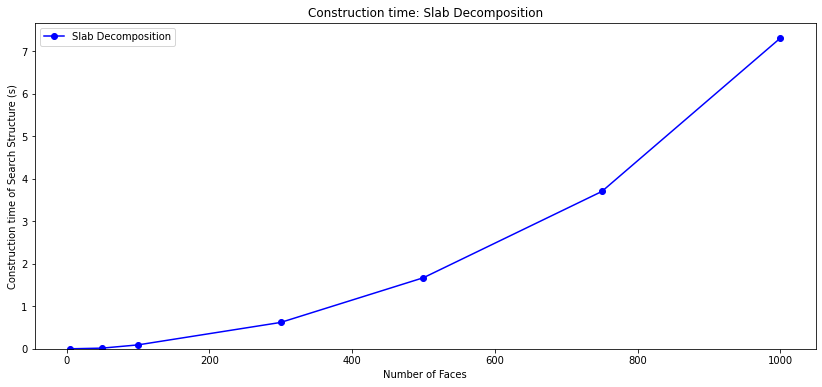

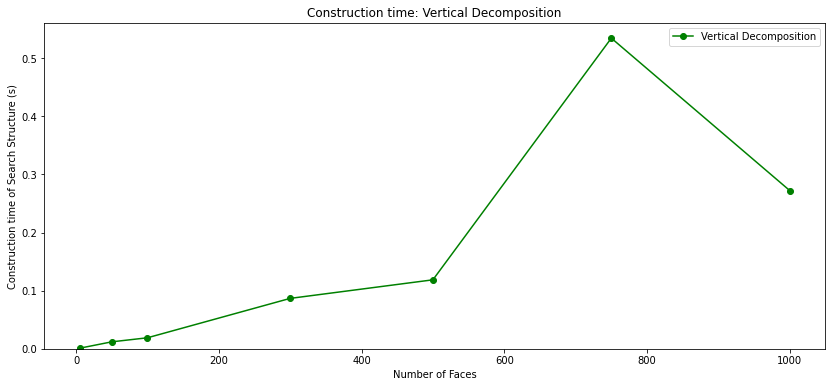

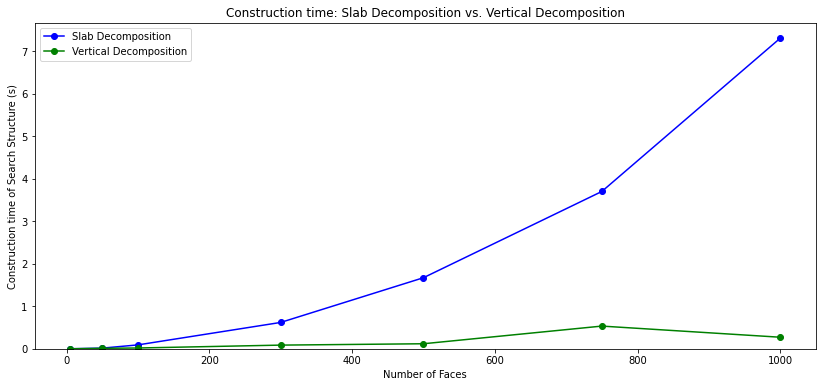

In [15]:
import matplotlib.pyplot as plt
# line 1 points
x1 = test_cases
y1 = slab_decomposition_construction_time
# plotting the line 1 points 
plt.plot(x1, y1, 'b', label = "Slab Decomposition", marker='o')
plt.xlabel('Number of Faces')
plt.ylabel('Construction time of Search Structure (s)')
plt.title('Construction time: Slab Decomposition')
plt.legend()
plt.ylim(ymin=0)
plt.show()

x2 = test_cases
y2 = vertical_decomposition_construction_time
# plotting the line 2 points 
plt.plot(x2, y2, 'g', label = "Vertical Decomposition", marker='o')
plt.xlabel('Number of Faces')
plt.ylabel('Construction time of Search Structure (s)')
plt.title('Construction time: Vertical Decomposition')
plt.legend()
plt.ylim(ymin=0)
plt.show()

plt.plot(x1, y1, 'b', label = "Slab Decomposition", marker='o')
plt.plot(x2, y2, 'g',  label = "Vertical Decomposition", marker='o')
plt.xlabel('Number of Faces')
plt.ylabel('Construction time of Search Structure (s)')
plt.title('Construction time: Slab Decomposition vs. Vertical Decomposition')
plt.legend()
plt.ylim(ymin=0)

#
plt.show()


When interpreting the result we have to take into account that these are live calculated. There are many factors that could influence the actual performance in practice (number of processes running, temperature of cpu, etc...). One might want to redo these tests a few times to get more confidence in the general tendency of these plots. It should however be clear that we see rather quadratic kind of growth in the construction time of the search structure of the slab decomposition. On the contrary not such a steep growth can be observed in the vertical decomposition. In particular the construction time does not grow significantly when the number of faces grows which makes the type of growth hard to determine just by means of a plot. However, when both graphs are put into the same plot, we can see a clear difference between the construction time and their corresponding growth. Indeed, vertical decomposition seems to be significantly faster.

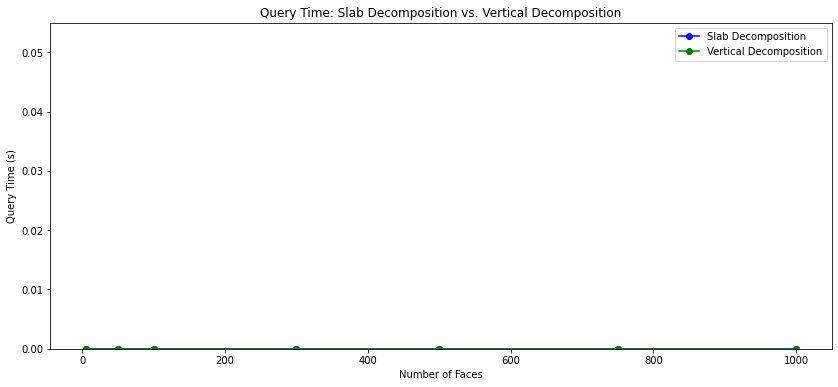

In [16]:
import matplotlib.pyplot as plt
# line 1 points
x1 = test_cases
y1 = slab_decomposition_query_time
# plotting the line 1 points 
plt.plot(x1, y1, 'b', label = "Slab Decomposition", marker='o')
# line 2 points
x2 = test_cases
y2 = vertical_decomposition_query_time
# plotting the line 2 points 
plt.plot(x2, y2, 'g', label = "Vertical Decomposition", marker='o')
plt.xlabel('Number of Faces')
# Set the y axis label of the current axis.
plt.ylabel('Query Time (s)')
# Set a title of the current axes.
plt.title('Query Time: Slab Decomposition vs. Vertical Decomposition')
# show a legend on the plot
plt.legend()
# Display a figure.

#
plt.ylim(ymin=0)
#
plt.show()

As we can see in the graph, both slab decomposition and vertical decomposition have similar kind of growth in query time. They also lie very close to each other. Therefore it does not seem to make much of a difference on the given example which one is used for the actual query.

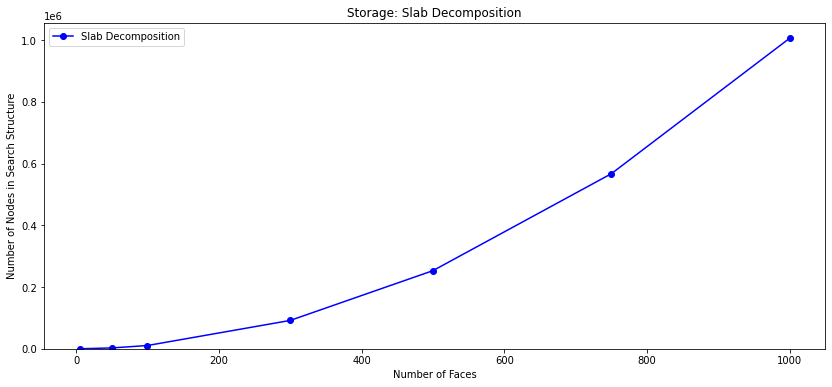

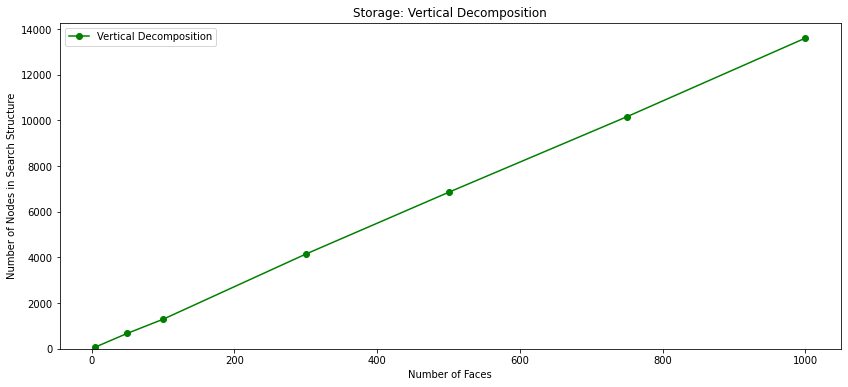

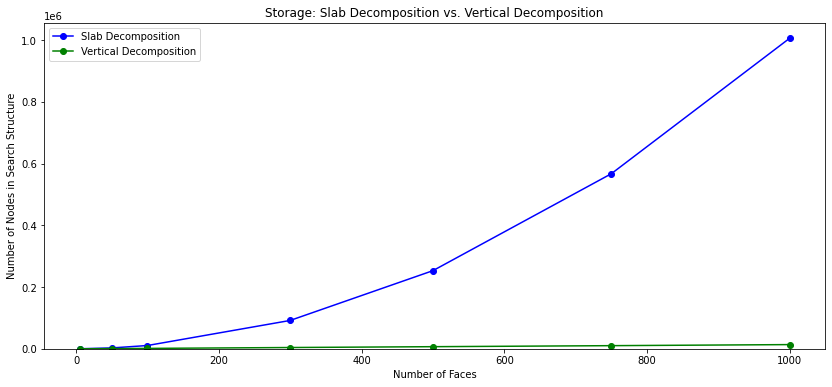

In [17]:
import matplotlib.pyplot as plt
# line 1 points
x1 = test_cases
y1 = slab_decomposition_nodes
# plotting the line 1 points 
plt.plot(x1, y1, 'b', label = "Slab Decomposition", marker='o')
plt.xlabel('Number of Faces')
plt.ylabel('Number of Nodes in Search Structure')
plt.title('Storage: Slab Decomposition')
plt.legend()
plt.ylim(ymin=0)
plt.show()

x2 = test_cases
y2 = vertical_decomposition_nodes
# plotting the line 2 points 
plt.plot(x2, y2, 'g', label = "Vertical Decomposition", marker='o')
plt.xlabel('Number of Faces')
plt.ylabel('Number of Nodes in Search Structure')
plt.title('Storage: Vertical Decomposition')
plt.legend()
plt.ylim(ymin=0)
plt.show()

plt.plot(x1, y1, 'b', label = "Slab Decomposition", marker='o')
plt.plot(x2, y2, 'g', label = "Vertical Decomposition", marker='o')
plt.xlabel('Number of Faces')
plt.ylabel('Number of Nodes in Search Structure')
plt.title('Storage: Slab Decomposition vs. Vertical Decomposition')
plt.legend()
plt.ylim(ymin=0)

#
plt.show()


In the first graph of Slab Decomposition we observe a quadratic curve. This in line with our expectancy about the storage growth of $\Theta(n^2)$. In the second image we see a very clear linear growth. In particular it seems that the number of nodes in the search structure grows with factor $13$ with respect to the number of faces. When both are plotted in the same image, one can clearly see what a significant difference this make in practice.

#### Special case: Comparison between Slab Decomposition and Vertical Decomposition Algorithm

Lastly we will have a look at a special case for planar subdivision generation. The special property of this generator function is that it creates planar subdivisions that expand only horizontally. Let’s have a look at a planar subdivision consisting of 10 segments.




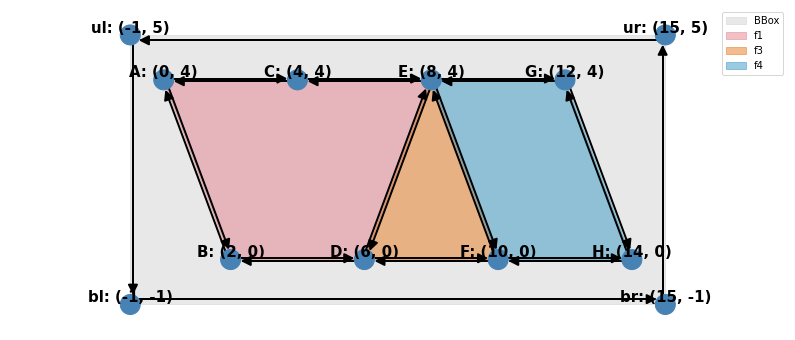

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]  # Set default size of matplot plots in jupyter notebook
import graph_generation.graph_generator as generator
import backend.slab_decomposition as sd
import complex_algorithm.algorithm as ca

points, segments = generator.create_horizontal_graph(10)
myDCEL = dcel.Dcel()
myDCEL.build_dcel(points, segments)
myDCEL.show_dcel()

The number of faces the planar subdivision consists of is chosen at random. The subdivison will contain at least one face and will be at most linear to the number of segments, so $O(n)$. To better explain how the generator function works let's have a look at the following figure.

![title](images/horizontal-generation.png)

The generator function will always make sure to realise a 'closed' entity, so the black edges will always exists. But the blue edges are added at random in such a way that the requested number of segments given as input is reached at the end. So for the input of 10 segments given above, it could also be the case that one very long shape is created without any blue edges or a very short shape is created with every possible blue edge existing. This way we have that the number of faces of the resulting shape is randomly formed.

If we would now realise the slabs for the slab decomposition it would look as follows.

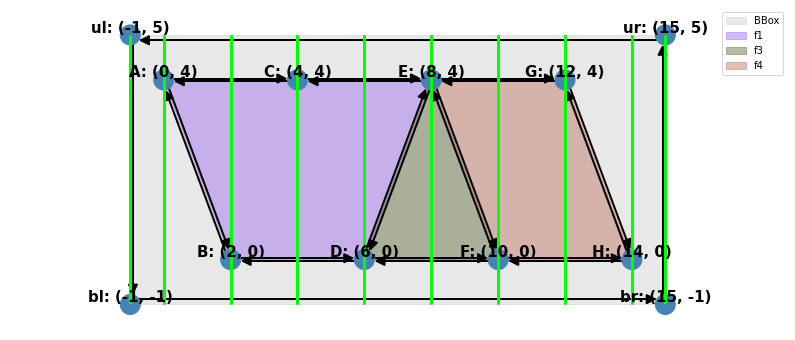

In [31]:
slab_decomposition = sd.SlabDecomposition(myDCEL)
slab_decomposition.show_slab_decomposition()

The big disadvantage of slab decomposition is the quadratic storage requirement of $O(n^2)$. This came into existence because we first have an $O(n)$ storage requirement for the binary search tree of the slabs. Each slab also contains a binary search tree for the edges that intersect that slab, which in a normal setting is also $O(n)$ resulting in the $O(n^2)$ storage requirement.

But in this case if we take a look at the slabs, we see that each slab only has only 2 or 3 edges intersecting the slab. So this might help with this large storage requirement. Let's find out.

In [45]:
import time

test_cases = [5, 50, 100, 300, 500, 750, 1000]

slab_decomposition_construction_time = []
slab_decomposition_query_time = []
slab_decomposition_nodes = []


vertical_decomposition_construction_time = []
vertical_decomposition_query_time = []
vertical_decomposition_nodes = []



for case in test_cases:
    number_of_segments = case
    points, segments = generator.create_horizontal_graph(number_of_segments)
    myDCEL = dcel.Dcel()
    myDCEL.build_dcel(points, segments)


    start = time.time()
    slab_decomposition = sd.SlabDecomposition(myDCEL)
    end = time.time()
    construction_time = end - start
    slab_decomposition_construction_time.append(construction_time)
    print("Slab decomposition: Construction with " + str(number_of_faces) + " faces uses "+ str(construction_time) + " seconds ")

    query_point = QueryPoint(0, number_of_faces-0.5) # To get a query point entirely on top
    start = time.time()
    t = slab_decomposition.solve_for_point(query_point, False)
    end = time.time()
    query_time = end - start
    slab_decomposition_query_time.append(query_time)
    print("Slab decomposition: Time to query a point is " + str(query_time) + " seconds ")
    
    structure_size = slab_decomposition.get_size_total()
    slab_decomposition_nodes.append(structure_size)
    print("Slab decomposion: Size of the search structure " + str(structure_size) + " nodes ")


    start = time.time()
    search_structure, trapezoidal_map = ca.trapezoidal_map_algorithm(myDCEL)
    end = time.time()
    construction_time = end - start
    vertical_decomposition_construction_time.append(construction_time)
    print("Vertical decomposition: Construction with " + str(number_of_faces) + " faces uses "+ str(construction_time) + " seconds ")

    query_point = QueryPoint(0, number_of_faces-0.5) # To get a query point entirely on top
    start = time.time()
    t = search_structure.query(query_point).trapezoid
    end = time.time()
    query_time = end - start
    vertical_decomposition_query_time.append(query_time)
    print("Vertical decomposition: Time to query a point is " + str(query_time) + " seconds ")
    
    structure_size = search_structure.get_size()
    vertical_decomposition_nodes.append(structure_size)
    print("Vertical decomposition decomposion: Size of the search structure " + str(structure_size) + " nodes ")

Slab decomposition: Construction with 5 faces uses 0.0009982585906982422 seconds 
Slab decomposition: Time to query a point is 0.0 seconds 
Slab decomposion: Size of the search structure 18 nodes 
Vertical decomposition: Construction with 5 faces uses 0.0009980201721191406 seconds 
Vertical decomposition: Time to query a point is 0.0 seconds 
Vertical decomposition decomposion: Size of the search structure 22 nodes 
Slab decomposition: Construction with 5 faces uses 0.0019941329956054688 seconds 
Slab decomposition: Time to query a point is 0.0 seconds 
Slab decomposion: Size of the search structure 121 nodes 
Vertical decomposition: Construction with 5 faces uses 0.0019943714141845703 seconds 
Vertical decomposition: Time to query a point is 0.0 seconds 
Vertical decomposition decomposion: Size of the search structure 194 nodes 
Slab decomposition: Construction with 5 faces uses 0.0030252933502197266 seconds 
Slab decomposition: Time to query a point is 0.0 seconds 
Slab decomposion: 

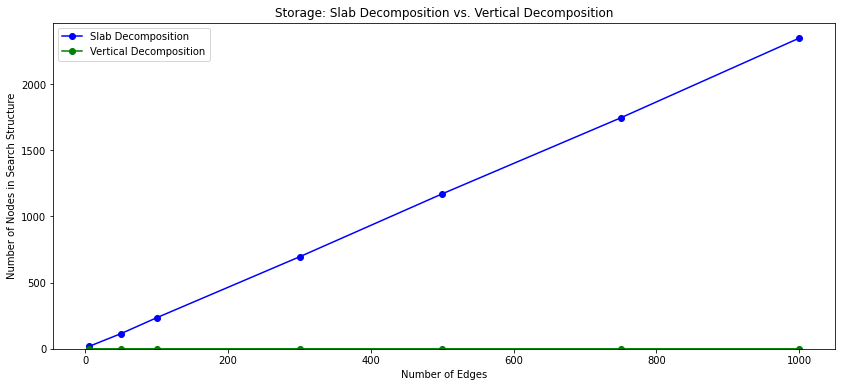

In [39]:
import matplotlib.pyplot as plt
# line 1 points
x1 = test_cases
y1 = slab_decomposition_nodes

plt.plot(x1, y1, 'b', label = "Slab Decomposition", marker='o')
plt.plot(x2, y2, 'g', label = "Vertical Decomposition", marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('Number of Nodes in Search Structure')
plt.title('Storage: Slab Decomposition vs. Vertical Decomposition')
plt.legend()
plt.ylim(ymin=0)

#
plt.show()

Indeed! Under the context of these graphs, the storage requirement of slab decomposition grows linearly. We now have that the binary search tree of a single slab has a size requirement of $O(1)$. The binary search tree containing all slabs still has size $O(n)$, which gives us a total size requirement of $O(n)$. An interesting observation is that the constant in the linear storage requirement for slab decomposition seems to be smaller than the constant in the linear storage requirement for vertical decomposition. 

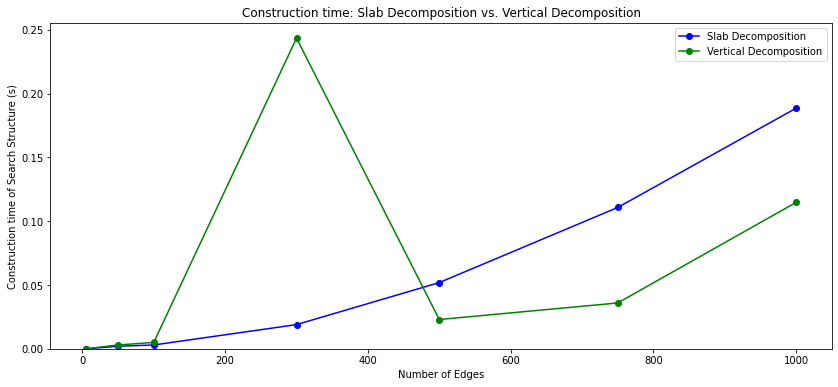

In [37]:
import matplotlib.pyplot as plt
# line 1 points
x1 = test_cases
y1 = slab_decomposition_construction_time

plt.plot(x1, y1, 'b', label = "Slab Decomposition", marker='o')
plt.plot(x2, y2, 'g',  label = "Vertical Decomposition", marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('Construction time of Search Structure (s)')
plt.title('Construction time: Slab Decomposition vs. Vertical Decomposition')
plt.legend()
plt.ylim(ymin=0)

#
plt.show()

In [44]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print(slab_decomposition_query_time)
print(vertical_decomposition_query_time)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


For the construction time we find a similar improvement for the slap decomposition algorithm. It didn't make sense to plot the query time as for this simple setting, both algorithms found the results instantly for all test cases.